In [29]:
!pip install kmodes
!pip install gower


In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
df = X


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler

df: pd.DataFrame = X

print(df.shape)
df = df[~df.eq("?").any(axis=1)]
df = df.dropna().reset_index(drop=True)

print(df.shape)

df.to_csv("adults.csv", index=False)

# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns


# df = pd.get_dummies(df, columns=categorical_cols)

# cat_cols = df.select_dtypes(include=['object', 'category']).columns
categorical_indexes = [df.columns.get_loc(col) for col in categorical_cols]

categorical_indexes

for col in categorical_cols:
    df[col], _ = pd.factorize(df[col])
    
# df[numerical_cols]  = MinMaxScaler().fit_transform(df[numerical_cols])
    
df

(48842, 14)
(45222, 14)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,0,77516,0,13,0,0,0,0,0,2174,0,40,0
1,50,1,83311,0,13,1,1,1,0,0,0,0,13,0
2,38,2,215646,1,9,2,2,0,0,0,0,0,40,0
3,53,2,234721,2,7,1,2,1,1,0,0,0,40,0
4,28,2,338409,0,13,1,3,2,1,1,0,0,40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,33,2,245211,0,13,0,3,3,0,0,0,0,40,0
45218,39,2,215419,0,13,2,3,0,0,1,0,0,36,0
45219,38,2,374983,0,13,1,3,1,0,0,0,0,50,0
45220,44,2,83891,0,13,2,0,3,2,0,5455,0,40,0


In [24]:
import gower
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

new_df: pd.DataFrame = X

new_df = new_df[~new_df.eq("?").any(axis=1)]
new_df = new_df.dropna().reset_index(drop=True)
mini_df = new_df.sample(10000)

gower_dist = gower.gower_matrix(mini_df)
full_results = []

epsilon_values = np.arange(0.05, 1.05, 0.05)
min_samples_values = range(2, 101, 2)

max_score = -1
# Run DBSCAN on the Gower distance matrix

for epsilon in epsilon_values:
    for min_sample in min_samples_values:
        dbscan = DBSCAN(metric='precomputed', eps=epsilon, min_samples=min_sample)
        labels = dbscan.fit_predict(gower_dist)
        number_of_labels = len(set(labels))
        if number_of_labels == 1:
            print(f"{epsilon=}, {min_sample=} classification is bad")
            full_results.append([epsilon, min_sample, np.NaN])            
            continue


        # Compute silhouette score only on non-noise points
        score_with_bad = silhouette_score(gower_dist, labels, metric='precomputed')

        if score_with_bad >= max_score:
            max_score = score_with_bad
            print(f"{epsilon=}, {min_sample=}, {score_with_bad=}")
            
        full_results.append([epsilon, min_sample, score_with_bad])
        
# import pickle


# with open("gower_matrix_dbscan.pkl", "wb") as f:
#     pickle.dump(full_results, f)




epsilon=0.05, min_sample=2, score_with_bad=0.31973743
epsilon=0.3, min_sample=2 classification is bad
epsilon=0.3, min_sample=4 classification is bad
epsilon=0.3, min_sample=6 classification is bad
epsilon=0.3, min_sample=8 classification is bad
epsilon=0.3, min_sample=10 classification is bad
epsilon=0.3, min_sample=12 classification is bad
epsilon=0.3, min_sample=14 classification is bad
epsilon=0.3, min_sample=16 classification is bad
epsilon=0.3, min_sample=18 classification is bad
epsilon=0.3, min_sample=20 classification is bad
epsilon=0.3, min_sample=22 classification is bad
epsilon=0.3, min_sample=24 classification is bad
epsilon=0.3, min_sample=26 classification is bad
epsilon=0.3, min_sample=28 classification is bad
epsilon=0.3, min_sample=30 classification is bad
epsilon=0.3, min_sample=32 classification is bad
epsilon=0.3, min_sample=34 classification is bad
epsilon=0.3, min_sample=36 classification is bad
epsilon=0.3, min_sample=38 classification is bad
epsilon=0.3, min_sa

In [28]:
dbscan_results = pd.DataFrame(full_results, columns=["epsilon", "min samples", "score"])
dbscan_results_pivot = dbscan_results.pivot(index="min samples", columns="epsilon", values="score")
dbscan_results_pivot

dbscan_results_pivot.to_csv("gower_dbscan.csv")

In [71]:
mask = labels != -1

# Compute silhouette score only on non-noise points
score = silhouette_score(gower_dist[mask][:, mask], labels[mask], metric='precomputed')
# score = silhouette_score(gower_dist, labels, metric='precomputed')

print("Silhouette Score:", score)

Silhouette Score: -0.016717758


In [9]:
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
import numpy as np

# Define the range of potential clusters and gamma values
clusters_range = [4]
gamma_range = np.linspace(0.1, 1, 10) # gamma values between 0.1 and 1

# Placeholder variables
best_score = -1
best_clusters = None
best_labels = None
best_gamma = None

all_scores = []

mini_df = df.sample(10000)

for n_clusters in clusters_range:
    # for gamma in gamma_range:
    kproto = KPrototypes(n_clusters=n_clusters)
    clusters = kproto.fit_predict(mini_df, categorical=categorical_indexes)
    score = silhouette_score(mini_df, clusters)
    all_scores.append([n_clusters, score, kproto.cost_])

    # Check if this configuration beats the best score
    print(f"{score=}, {n_clusters=}, {kproto.cost_=}")
    if score > best_score:
        best_labels = clusters
        best_score = score
        best_clusters = n_clusters
        # best_gamma = gamma

print(f"Best score: {best_score}")
print(f"Optimal number of clusters: {best_clusters}")
print(f"Optimal gamma value: {best_gamma}")
print(f"{all_scores}")

score=0.5550991148286488, n_clusters=4, kproto.cost_=18868743910650.02
Best score: 0.5550991148286488
Optimal number of clusters: 4
Optimal gamma value: None
[[4, 0.5550991148286488, 18868743910650.02]]


In [11]:
len(mini_df)

10000

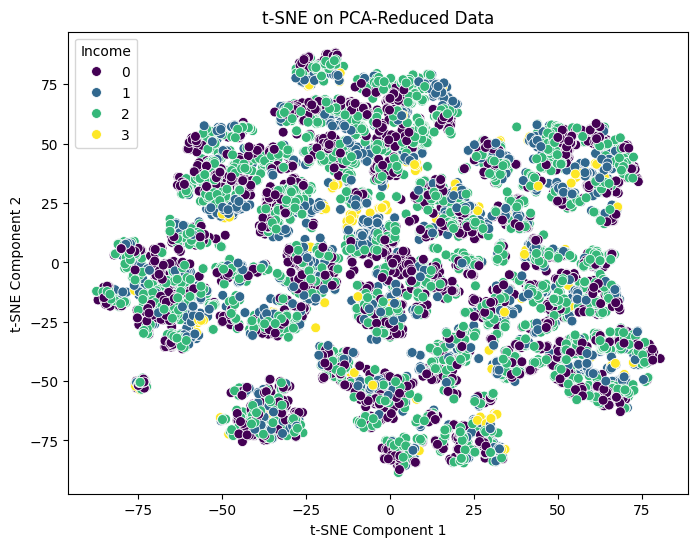

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

scaled_mini = StandardScaler().fit_transform(mini_df)

tsne = TSNE(n_components=2, perplexity=30)
tsne_on_df = tsne.fit_transform(scaled_mini)

def plot_tsne(X_tsne, title):
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=clusters, palette='viridis', s=50)
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Income')
    plt.show()

# Visualizations
plot_tsne(tsne_on_df, 't-SNE on PCA-Reduced Data')

In [6]:
gower_dist

array([[0.        , 0.39328548, 0.47711834, ..., 0.4032342 , 0.5187556 ,
        0.39829972],
       [0.39328548, 0.        , 0.38589963, ..., 0.23889093, 0.42574376,
        0.31490883],
       [0.47711834, 0.38589963, 0.        , ..., 0.3280076 , 0.20147456,
        0.3945017 ],
       ...,
       [0.4032342 , 0.23889093, 0.3280076 , ..., 0.        , 0.37096944,
        0.22083198],
       [0.5187556 , 0.42574376, 0.20147456, ..., 0.37096944, 0.        ,
        0.43746355],
       [0.39829972, 0.31490883, 0.3945017 , ..., 0.22083198, 0.43746355,
        0.        ]], dtype=float32)

In [16]:
from sklearn.cluster import HDBSCAN


hdbscan = HDBSCAN(metric='precomputed')
hdbscan_labels = hdbscan.fit_predict(gower_dist)
number_of_labels = len(set(hdbscan_labels))


score = silhouette_score(gower_dist, hdbscan_labels, metric='precomputed')
print(f"{number_of_labels=}, {score}")


number_of_labels=354, 0.08060208708047867


In [ ]:
results_dict = {"K-prototype": clusters, "DBSCAN": labels, "HDBSCAN": hdbscan_labels}

# y = y.loc[mini_df.index]
# y = y["income"].str.strip(".")
y = (y == ">50K").astype(int)

import numpy as np
import pandas as pd
from scipy.stats import chisquare

def evaluate_clusters(clusters_dict, labels):
    """
    Evaluate clustering results by Chi-Square test against ground truth labels (>50K, <50K).
    
    Args:
        clusters_dict (dict): {algorithm_name: cluster_assignments (np.array)}
        labels (pd.Series): Ground truth labels (0/1), aligned with clustering.

    Returns:
        pd.DataFrame: Table with Chi2 statistic, p-value, Cramer's V per algorithm.
    """
    alpha = 0.05  # 95% significance level
    
    chi2_results = []

    for algo, clusters in clusters_dict.items():
        clusters = np.array(clusters)

        # Filter out noise points (-1) if exist
        mask = clusters != -1
        clean_clusters = clusters[mask]
        clean_labels = labels.iloc[mask]

        K = len(np.unique(clean_clusters))  # number of clusters (after noise removal)

        # If only 1 cluster (bad clustering), skip
        if K <= 1:
            chi2_results.append({
                'algorithm': algo,
                'K': K,
                'chi2': np.nan,
                'chi2_p': np.nan,
                'cramer_v': np.nan
            })
            continue

        df = pd.DataFrame({
            'label': clean_labels.values,
            'cluster': clean_clusters
        })

        # --- Chi-Square Test ---
        obs = df.groupby('cluster')['label'].sum().sort_index().values    # observed >50K per cluster
        n_k = df['cluster'].value_counts().sort_index().values            # cluster sizes
        p_global = df['label'].mean()                                     # global proportion >50K
        exp = n_k * p_global                                              # expected >50K if random

        chi2_stat, p_chi2 = chisquare(f_obs=obs, f_exp=exp)

        # --- Cramer's V (effect size) ---
        N = len(df)
        cramer_v = np.sqrt(chi2_stat / (N * (K - 1)))

        chi2_results.append({
            'algorithm': algo,
            'K': K,
            'chi2': chi2_stat,
            'chi2_p': p_chi2,
            'cramer_v': cramer_v
        })

    # Collect all results
    chi2_df = pd.DataFrame(chi2_results)
    return chi2_df


evaluate_clusters(results_dict, y)

In [ ]:
import numpy as np
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

mds = MDS(dissimilarity='precomputed')
X_embedded = mds.fit_transform(gower_dist)

# Fit GMM

gmm = GaussianMixture(n_components=2)
labels = gmm.fit_predict(X_embedded)

# Compute Silhouette Score
score = silhouette_score(X_embedded, labels)
print(f"Silhouette Score: {score:.3f}")

In [ ]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

k_prototype_cao = [47600340443889.32,
26250635086135.605,
17651557379011.86,
12930092690963.555,
9669832064624.227,
7034531985936.423,
5450677488713.95,
4397565147883.036, 3729302490553.4453]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(2 * 6, 2 * 4))
axes = axes.flatten()

axes[0].plot(k_prototype_cao)
axes[0].set_title("K-prototype Cao method")
axes[0].set_xlabel("Number of clusters")
axes[0].set_ylabel("Loss")
axes[0].set_text("A", loc='left', fontsize=14, fontweight='bold')

k_prototype_huang = [46519926248627.34,
25313973469048.527,
16507028427320.635,
11741704274283.936,
8474958772991.547,
6388010631914.506,
5250316111419.136,
4366122597697.0127,
3493980705628.491,
3069157689652.015]



axes[1].plot(k_prototype_huang)
axes[1].set_title("K-prototype Huang method")
axes[1].set_xlabel("Number of clusters")
axes[1].set_ylabel("Loss")

import pandas as pd

dbscan_gower = pd.read_csv("gower_dbscan.csv")
dbscan_gower = dbscan_gower.fillna(-1)

palette = sns.color_palette("tab10") + sns.color_palette("pastel") + sns.color_palette("Set2")
colors = [palette[j % len(palette)] for j in range(4)]
sns.heatmap(dbscan_gower, fmt=".2f", cmap="viridis", linewidths=0.5, ax=axes[2])
axes[2].set_title(f"DBSCAN heatmap")
axes[2].set_xlabel("epsilon value")
axes[2].set_ylabel("min samples") 


algs = ["K-prototype (Cao)", "K-prototype (Huang)", "DBSCAN", "HDBSCAN"]
scores = [0.5309211677627476, 0.5552031118482339, 0.32381403, 0.08060208708047867]
axes[3].bar(algs, scores, color=colors, width=0.3)
axes[3].set_title(f"Silhouette Scores")
axes[3].set_ylabel("Score")
axes[3].set_xlabel("Clustering Algorithm")


plt.tight_layout()
plt.savefig('mixed_data_methods.pdf', bbox_inches='tight')
plt.show()
